# Titanic

## 导入本次需要的包

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.utils.data as Data
import urllib.request
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from torchsummary import summary
from matplotlib.font_manager import FontProperties

torch.__version__

'1.6.0'

## 数据预处理

具体的数据处理方式可以参见[Tensorflow 笔记 Ⅵ——Titanic Keras建模与应用](https://blog.csdn.net/qq_39567427/article/details/105843934)，里面有详细的梳理，这里就不在赘述

In [2]:
def prepare_data(df_data):
    # 去掉name列，name对于数据特征没有贡献
    df = df_data.drop(['name'], axis=1)
    # 获取age列均值用于补充age列的空值
    age_mean = df['age'].mean()
    df['age'] = df['age'].fillna(age_mean)
    # 获取fare列均值用于补充fare列的空值
    fare_mean = df['fare'].mean()
    df['fare'] = df['fare'].fillna(fare_mean)
    # 性别映射关系，将female映射为0，male映射为1
    df['sex'] = df['sex'].map({'female':0, 'male':1}).astype(int)
    # 将embarked列空值填充为S
    df['embarked'] = df['embarked'].fillna('S')
    # 再将embarked列所有英文字母映射为数字，按照C:0，Q:1，S:2的标准
    df['embarked'] = df['embarked'].map({'C':0, 'Q':1, 'S':2}).astype(int)

    # 将数据转换为数组
    ndarray_data = df.values

    features = ndarray_data[:, 1:]
    label = ndarray_data[:, 0]

    minmax_scale = preprocessing.MinMaxScaler(feature_range=(0, 1))
    norm_features = minmax_scale.fit_transform(features)

    return norm_features, label


读取`.xls`文件需要安装`xlrd`模块

In [3]:
dataframe = pd.read_excel('./titanic/titanic3.xls')

# 选择特征贡献的列
selected_cols= ['survived', 'name', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']
# 生成副本，以免出现警告
selected_dataframe = dataframe[selected_cols].copy()
# 随机打乱，frac=1表示100％打乱
selected_dataframe = selected_dataframe.sample(frac=1)

x_data, y_data = prepare_data(selected_dataframe)

# 划分训练集及验证集，比例为8：2（4：1）
train_size = int(len(x_data) * 0.8)

x_train = x_data[:train_size]
y_train = y_data[:train_size]

x_test = x_data[train_size:]
y_test = y_data[train_size:]

## 数据集生成

In [4]:
BATCH_SIZE = 50

train_dataset = Data.TensorDataset(torch.from_numpy(x_train).type(torch.FloatTensor), torch.from_numpy(y_train).type(torch.LongTensor))
train_loader = Data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = Data.TensorDataset(torch.from_numpy(x_test).type(torch.FloatTensor), torch.from_numpy(y_test).type(torch.LongTensor))
test_loader = Data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE * 5, shuffle=True)

## 获取设备信息

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cuda:0


## 开始训练

模型构建DNN

In [6]:
class DNN(nn.Module):
    def __init__(self, inputdim):
        super(DNN, self).__init__()
        self.dnn = nn.Sequential(
            nn.Linear(inputdim, 32),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.Dropout(0.2),
            nn.Sigmoid(),
            nn.Linear(16, 2),
            nn.Dropout(0.1),
            nn.Sigmoid()
        )

    def forward(self, inputs):
        return self.dnn(inputs)

In [7]:
dnn = DNN(inputdim=7).to(device)

summary(dnn, input_size=(7,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 32]             256
           Dropout-2                   [-1, 32]               0
              ReLU-3                   [-1, 32]               0
            Linear-4                   [-1, 16]             528
           Dropout-5                   [-1, 16]               0
           Sigmoid-6                   [-1, 16]               0
            Linear-7                    [-1, 2]              34
           Dropout-8                    [-1, 2]               0
           Sigmoid-9                    [-1, 2]               0
Total params: 818
Trainable params: 818
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
---------------------------------------------------

超参数设置

In [8]:
EPOCHS = 500
LR = 0.001

权重重置函数

In [9]:
def weight_reset(m):
    if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.Linear):
        m.reset_parameters()

定义优化器与损失函数

In [10]:
optimizer = torch.optim.Adam(dnn.parameters(), lr=LR)
loss_func = nn.CrossEntropyLoss()

开始训练

In [11]:
%%time

# 权重初始化
dnn.apply(weight_reset)
# 生成迭代器
dataiter = iter(test_loader)

train_acc_list = []
test_acc_list = []
train_loss_list = []
test_loss_list = []

for epoch in range(EPOCHS):
    train_step_acc = []
    train_step_loss = []
    test_step_loss = []
    test_step_acc = []
    for step, data in enumerate(train_loader):
        # 数据提取并转为GPU形式
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # 结果预测并获取预测值
        outputs = dnn(inputs)
        train_pred_y = torch.max(outputs, 1)[1].data.squeeze()
        # 获取准确率
        train_acc = (train_pred_y == labels).sum().item() / float(labels.size(0))
        # 获取损失值
        loss = loss_func(outputs, labels)
        train_step_loss.append(float(loss))
        train_step_acc.append(train_acc)
        
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        try:
            test_inputs, test_labels = next(dataiter)
        except StopIteration:
            dataiter = iter(test_loader)
            test_inputs, test_labels = next(dataiter)
        
        # 数据提取并转为GPU形式
        test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
        # 结果预测并获取预测值
        test_outputs = dnn(test_inputs)
        test_pred_y = torch.max(test_outputs, 1)[1].data.squeeze()
        # 获取准确率
        test_acc = (test_pred_y == test_labels).sum().item() / float(test_labels.size(0))
        test_step_acc.append(test_acc)
        # 获取损失值
        test_loss = loss_func(test_outputs, test_labels)
        test_step_loss.append(float(test_loss))
        test_step_acc.append(test_acc)
        
    train_acc_list.append(np.mean(train_step_acc))
    train_loss_list.append(np.mean(train_step_loss))
    test_acc_list.append(np.mean(test_step_acc))
    test_loss_list.append(np.mean(test_step_loss))
    
    print(('EPOCH={:3d}/{:3d}, train_loss={:.4f}, '
           'train_acc={:.4f}, valid_loss={:.4f}, val_acc={:.4f}').format(epoch + 1,
                                                                EPOCHS,
                                                                np.mean(train_step_loss),
                                                                np.mean(train_step_acc),
                                                                np.mean(test_step_loss),
                                                                np.mean(test_step_acc)))

EPOCH=  1/500, train_loss=0.6845, train_acc=0.5990, valid_loss=0.6830, val_acc=0.6179
EPOCH=  2/500, train_loss=0.6762, train_acc=0.6104, valid_loss=0.6702, val_acc=0.6510
EPOCH=  3/500, train_loss=0.6751, train_acc=0.5882, valid_loss=0.6728, val_acc=0.6110
EPOCH=  4/500, train_loss=0.6694, train_acc=0.6159, valid_loss=0.6632, val_acc=0.6291
EPOCH=  5/500, train_loss=0.6631, train_acc=0.6124, valid_loss=0.6702, val_acc=0.5873
EPOCH=  6/500, train_loss=0.6609, train_acc=0.6169, valid_loss=0.6608, val_acc=0.6122
EPOCH=  7/500, train_loss=0.6567, train_acc=0.6150, valid_loss=0.6560, val_acc=0.6171
EPOCH=  8/500, train_loss=0.6548, train_acc=0.6114, valid_loss=0.6493, val_acc=0.6116
EPOCH=  9/500, train_loss=0.6529, train_acc=0.6075, valid_loss=0.6419, val_acc=0.6183
EPOCH= 10/500, train_loss=0.6429, train_acc=0.6174, valid_loss=0.6327, val_acc=0.6337
EPOCH= 11/500, train_loss=0.6326, train_acc=0.6227, valid_loss=0.6228, val_acc=0.6381
EPOCH= 12/500, train_loss=0.6275, train_acc=0.6189, va

EPOCH= 97/500, train_loss=0.5365, train_acc=0.7918, valid_loss=0.4956, val_acc=0.8368
EPOCH= 98/500, train_loss=0.5359, train_acc=0.7812, valid_loss=0.4968, val_acc=0.8321
EPOCH= 99/500, train_loss=0.5317, train_acc=0.7920, valid_loss=0.4736, val_acc=0.8530
EPOCH=100/500, train_loss=0.5326, train_acc=0.7843, valid_loss=0.4810, val_acc=0.8591
EPOCH=101/500, train_loss=0.5332, train_acc=0.7878, valid_loss=0.4889, val_acc=0.8334
EPOCH=102/500, train_loss=0.5299, train_acc=0.7888, valid_loss=0.5176, val_acc=0.7945
EPOCH=103/500, train_loss=0.5355, train_acc=0.7851, valid_loss=0.4843, val_acc=0.8477
EPOCH=104/500, train_loss=0.5268, train_acc=0.7861, valid_loss=0.5138, val_acc=0.8060
EPOCH=105/500, train_loss=0.5356, train_acc=0.7852, valid_loss=0.5216, val_acc=0.8096
EPOCH=106/500, train_loss=0.5345, train_acc=0.7871, valid_loss=0.4663, val_acc=0.8599
EPOCH=107/500, train_loss=0.5328, train_acc=0.7872, valid_loss=0.4911, val_acc=0.8221
EPOCH=108/500, train_loss=0.5312, train_acc=0.7853, va

EPOCH=193/500, train_loss=0.5231, train_acc=0.7874, valid_loss=0.4772, val_acc=0.8438
EPOCH=194/500, train_loss=0.5266, train_acc=0.7909, valid_loss=0.4918, val_acc=0.8280
EPOCH=195/500, train_loss=0.5260, train_acc=0.7906, valid_loss=0.4902, val_acc=0.8279
EPOCH=196/500, train_loss=0.5254, train_acc=0.7939, valid_loss=0.5089, val_acc=0.7979
EPOCH=197/500, train_loss=0.5278, train_acc=0.7925, valid_loss=0.4807, val_acc=0.8366
EPOCH=198/500, train_loss=0.5262, train_acc=0.7920, valid_loss=0.4991, val_acc=0.8282
EPOCH=199/500, train_loss=0.5273, train_acc=0.7831, valid_loss=0.4828, val_acc=0.8419
EPOCH=200/500, train_loss=0.5244, train_acc=0.7955, valid_loss=0.4698, val_acc=0.8595
EPOCH=201/500, train_loss=0.5250, train_acc=0.7882, valid_loss=0.4846, val_acc=0.8443
EPOCH=202/500, train_loss=0.5233, train_acc=0.7965, valid_loss=0.4927, val_acc=0.8223
EPOCH=203/500, train_loss=0.5266, train_acc=0.7900, valid_loss=0.4913, val_acc=0.8328
EPOCH=204/500, train_loss=0.5269, train_acc=0.7908, va

EPOCH=289/500, train_loss=0.5253, train_acc=0.7861, valid_loss=0.4946, val_acc=0.8260
EPOCH=290/500, train_loss=0.5255, train_acc=0.7909, valid_loss=0.5128, val_acc=0.8135
EPOCH=291/500, train_loss=0.5275, train_acc=0.7821, valid_loss=0.4840, val_acc=0.8213
EPOCH=292/500, train_loss=0.5224, train_acc=0.7965, valid_loss=0.5027, val_acc=0.8004
EPOCH=293/500, train_loss=0.5282, train_acc=0.7908, valid_loss=0.4783, val_acc=0.8255
EPOCH=294/500, train_loss=0.5226, train_acc=0.7899, valid_loss=0.4860, val_acc=0.8321
EPOCH=295/500, train_loss=0.5271, train_acc=0.7955, valid_loss=0.4565, val_acc=0.8570
EPOCH=296/500, train_loss=0.5258, train_acc=0.7911, valid_loss=0.4760, val_acc=0.8369
EPOCH=297/500, train_loss=0.5247, train_acc=0.7946, valid_loss=0.5021, val_acc=0.8230
EPOCH=298/500, train_loss=0.5208, train_acc=0.7918, valid_loss=0.5035, val_acc=0.8255
EPOCH=299/500, train_loss=0.5268, train_acc=0.7869, valid_loss=0.4675, val_acc=0.8555
EPOCH=300/500, train_loss=0.5241, train_acc=0.7917, va

EPOCH=385/500, train_loss=0.5234, train_acc=0.7880, valid_loss=0.4844, val_acc=0.8364
EPOCH=386/500, train_loss=0.5238, train_acc=0.7862, valid_loss=0.4938, val_acc=0.8333
EPOCH=387/500, train_loss=0.5223, train_acc=0.7887, valid_loss=0.4817, val_acc=0.8292
EPOCH=388/500, train_loss=0.5214, train_acc=0.7995, valid_loss=0.5074, val_acc=0.8257
EPOCH=389/500, train_loss=0.5229, train_acc=0.7907, valid_loss=0.4931, val_acc=0.8220
EPOCH=390/500, train_loss=0.5259, train_acc=0.7915, valid_loss=0.5022, val_acc=0.8129
EPOCH=391/500, train_loss=0.5238, train_acc=0.7892, valid_loss=0.4932, val_acc=0.8250
EPOCH=392/500, train_loss=0.5271, train_acc=0.7980, valid_loss=0.4958, val_acc=0.8076
EPOCH=393/500, train_loss=0.5205, train_acc=0.7927, valid_loss=0.5191, val_acc=0.8056
EPOCH=394/500, train_loss=0.5222, train_acc=0.7948, valid_loss=0.4740, val_acc=0.8419
EPOCH=395/500, train_loss=0.5243, train_acc=0.7850, valid_loss=0.4779, val_acc=0.8460
EPOCH=396/500, train_loss=0.5181, train_acc=0.8002, va

EPOCH=481/500, train_loss=0.5235, train_acc=0.7936, valid_loss=0.4885, val_acc=0.8190
EPOCH=482/500, train_loss=0.5181, train_acc=0.7996, valid_loss=0.4736, val_acc=0.8323
EPOCH=483/500, train_loss=0.5236, train_acc=0.7918, valid_loss=0.4924, val_acc=0.8215
EPOCH=484/500, train_loss=0.5232, train_acc=0.7909, valid_loss=0.4868, val_acc=0.8215
EPOCH=485/500, train_loss=0.5223, train_acc=0.7975, valid_loss=0.4967, val_acc=0.8086
EPOCH=486/500, train_loss=0.5212, train_acc=0.7968, valid_loss=0.4905, val_acc=0.8249
EPOCH=487/500, train_loss=0.5146, train_acc=0.8014, valid_loss=0.4709, val_acc=0.8473
EPOCH=488/500, train_loss=0.5216, train_acc=0.7861, valid_loss=0.4734, val_acc=0.8461
EPOCH=489/500, train_loss=0.5173, train_acc=0.7955, valid_loss=0.4979, val_acc=0.8101
EPOCH=490/500, train_loss=0.5239, train_acc=0.7908, valid_loss=0.4905, val_acc=0.8446
EPOCH=491/500, train_loss=0.5264, train_acc=0.7956, valid_loss=0.4935, val_acc=0.8217
EPOCH=492/500, train_loss=0.5221, train_acc=0.7930, va

## 训练效果可视化

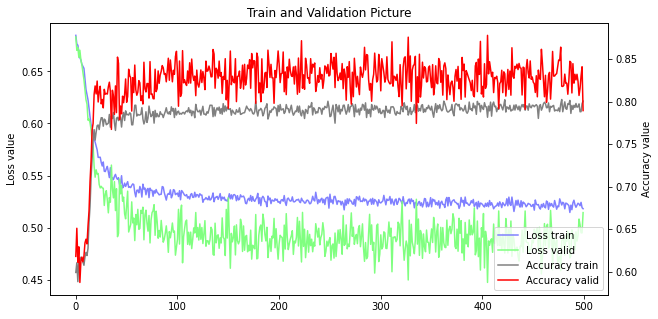

In [12]:
fig = plt.gcf()
fig.set_size_inches(10, 5)
ax1 = fig.add_subplot(111)
ax1.set_title('Train and Validation Picture')
ax1.set_ylabel('Loss value')
line1, = ax1.plot(train_loss_list, color=(0.5, 0.5, 1.0), label='Loss train')
line2, = ax1.plot(test_loss_list, color=(0.5, 1.0, 0.5), label='Loss valid')
ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy value')
line3, = ax2.plot(train_acc_list, color=(0.5, 0.5, 0.5), label='Accuracy train')
line4, = ax2.plot(test_acc_list, color=(1, 0, 0), label='Accuracy valid')
plt.legend(handles=(line1, line2, line3, line4), loc='best')
plt.show()

## 类别验证

In [13]:
test_loader = Data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE * 5, shuffle=True)

# 创建一个10维列表，存储后面每个类累计的值
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.view([-1, 7]).to(device), labels.to(device)
        # 独热码类型分布，输出为4x10的矩阵，分别表示batchsize：4以及类别：10
        outputs = dnn(inputs)
        predicted = torch.max(outputs, 1)[1]
        
        # 将输入张量形状中的 1 去除并返回，例如[1, 2, 3]
        # 返回[2, 3]，当给定 dim 时，那么挤压操作只在给定维度
        # 在这里由于返回的bool值，可以不使用.squeeze()操作
        c = (predicted == labels).squeeze()
        # 循环遍历每一个批次
        for i in range(labels.size()[0]):
            label = labels[i]
            # 获取具体值
            class_correct[label] += c[i].item()
            # 对应类别自加
            class_total[label] += 1

for i in range(2):
    print('Accuracy of %s : %2d %%' % (
        i, 100 * class_correct[i] / class_total[i]))

Accuracy of 0 : 92 %
Accuracy of 1 : 69 %


## Jack & Rose

In [14]:
'''
Jack_info = [0, 'Jack', 3, 'male', 23, 1, 0, 5.0000, 'S']=[3, 1, 23, 1, 0, 5.0000, 2]
Rose_info = [1, 'Rose', 1, 'female', 20, 1, 0, 100.0000, 'S']=[1, 0, 20, 1, 0, 100.0000, 2]
'''
# 按照数据集进行同样的归一化
minmax_scale = preprocessing.MinMaxScaler(feature_range=(0, 1))
couple = minmax_scale.fit_transform(np.array([[3, 1, 23, 1, 0, 5.0000, 2], [1, 0, 20, 1, 0, 100.0000, 2]]))

couple = torch.from_numpy(couple).type(torch.FloatTensor).to(device)
outputs = dnn(couple)
predicted = torch.max(outputs, 1)[1]


print('Rose survived probability: %.5f'% outputs[0][predicted[0]].item(),
      '\nRose is survival',
      '\nJack survived probability: %.5f'%outputs[1][predicted[0]].item(),
      '\nJack is not survival')

Rose survived probability: 0.99981 
Rose is survival 
Jack survived probability: 0.00043 
Jack is not survival


# Breast Cancer

## 数据读取与展示

导入数据读取模块，读取数据

In [15]:
from sklearn.datasets import load_breast_cancer

breast_cancer = load_breast_cancer()

查看数据特征以及标签的维度

In [16]:
print('data features shape:', breast_cancer['data'].shape,
      '\ndata labels shape  :', breast_cancer['target'].shape)

data features shape: (569, 30) 
data labels shape  : (569,)


查看特征名

In [17]:
for name in breast_cancer['feature_names']:
    print(name, end=' ')
print('\n\n特征数量: ', len(breast_cancer['feature_names']))

mean radius mean texture mean perimeter mean area mean smoothness mean compactness mean concavity mean concave points mean symmetry mean fractal dimension radius error texture error perimeter error area error smoothness error compactness error concavity error concave points error symmetry error fractal dimension error worst radius worst texture worst perimeter worst area worst smoothness worst compactness worst concavity worst concave points worst symmetry worst fractal dimension 

特征数量:  30


查看标签名，其标签的数字映射按照`target_names`排列顺序

In [18]:
for name in breast_cancer.target_names:
    print(name, list(breast_cancer.target_names).index(name), end=', ')
print('\n\n标签类别: ', len(breast_cancer.target_names))

malignant 0, benign 1, 

标签类别:  2


获取部分数据的标签以及训练数据

In [19]:
breast_cancer['data'][0]

array([1.799e+01, 1.038e+01, 1.228e+02, 1.001e+03, 1.184e-01, 2.776e-01,
       3.001e-01, 1.471e-01, 2.419e-01, 7.871e-02, 1.095e+00, 9.053e-01,
       8.589e+00, 1.534e+02, 6.399e-03, 4.904e-02, 5.373e-02, 1.587e-02,
       3.003e-02, 6.193e-03, 2.538e+01, 1.733e+01, 1.846e+02, 2.019e+03,
       1.622e-01, 6.656e-01, 7.119e-01, 2.654e-01, 4.601e-01, 1.189e-01])

In [20]:
breast_cancer.target[[1, 11, 111]]

array([0, 0, 1])

**注意：`sklearn`的数据集可以在sklearn安装包下查看得到，比如我的可以在`E:\Anaconda3\envs\pytorch1.6.0\Lib\site-packages\sklearn\datasets\data\breast_cancer.csv`，这个文件夹包含了`sklearn`所有集成的数据集**

## 数据归一化

In [22]:
minmax_scale = preprocessing.MinMaxScaler(feature_range=(0, 1))

train_dataset = Data.TensorDataset(torch.from_numpy(minmax_scale.fit_transform(breast_cancer['data'][:400])).type(torch.FloatTensor), torch.from_numpy(breast_cancer['target'][:400]).type(torch.LongTensor))
train_loader = Data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = Data.TensorDataset(torch.from_numpy(minmax_scale.fit_transform(breast_cancer['data'][400:])).type(torch.FloatTensor), torch.from_numpy(breast_cancer['target'][400:]).type(torch.LongTensor))
test_loader = Data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE * 5, shuffle=True)

## 开始训练

**注意：`Breast Cancer` 中未涉及的超参数，模型构建等均沿用前面部分**

In [21]:
dnn = DNN(inputdim=30).to(device)

summary(dnn, input_size=(30,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 32]             992
           Dropout-2                   [-1, 32]               0
              ReLU-3                   [-1, 32]               0
            Linear-4                   [-1, 16]             528
           Dropout-5                   [-1, 16]               0
           Sigmoid-6                   [-1, 16]               0
            Linear-7                    [-1, 2]              34
           Dropout-8                    [-1, 2]               0
           Sigmoid-9                    [-1, 2]               0
Total params: 1,554
Trainable params: 1,554
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
-----------------------------------------------

定义新的优化器，设置更小的学习率

In [23]:
optimizer = torch.optim.Adam(dnn.parameters(), lr=0.0001)

开始训练

In [24]:
%%time

# 权重初始化
dnn.apply(weight_reset)
# 生成迭代器
dataiter = iter(test_loader)

train_acc_list = []
test_acc_list = []
train_loss_list = []
test_loss_list = []

for epoch in range(EPOCHS):
    train_step_acc = []
    train_step_loss = []
    test_step_loss = []
    test_step_acc = []
    for step, data in enumerate(train_loader):
        # 数据提取并转为GPU形式
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # 结果预测并获取预测值
        outputs = dnn(inputs)
        train_pred_y = torch.max(outputs, 1)[1].data.squeeze()
        # 获取准确率
        train_acc = (train_pred_y == labels).sum().item() / float(labels.size(0))
        # 获取损失值
        loss = loss_func(outputs, labels)
        train_step_loss.append(float(loss))
        train_step_acc.append(train_acc)
        
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        try:
            test_inputs, test_labels = next(dataiter)
        except StopIteration:
            dataiter = iter(test_loader)
            test_inputs, test_labels = next(dataiter)
        
        # 数据提取并转为GPU形式
        test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
        # 结果预测并获取预测值
        test_outputs = dnn(test_inputs)
        test_pred_y = torch.max(test_outputs, 1)[1].data.squeeze()
        # 获取准确率
        test_acc = (test_pred_y == test_labels).sum().item() / float(test_labels.size(0))
        test_step_acc.append(test_acc)
        # 获取损失值
        test_loss = loss_func(test_outputs, test_labels)
        test_step_loss.append(float(test_loss))
        test_step_acc.append(test_acc)
        
    train_acc_list.append(np.mean(train_step_acc))
    train_loss_list.append(np.mean(train_step_loss))
    test_acc_list.append(np.mean(test_step_acc))
    test_loss_list.append(np.mean(test_step_loss))
    
    print(('EPOCH={:3d}/{:3d}, train_loss={:.4f}, '
           'train_acc={:.4f}, valid_loss={:.4f}, val_acc={:.4f}').format(epoch + 1,
                                                                EPOCHS,
                                                                np.mean(train_step_loss),
                                                                np.mean(train_step_acc),
                                                                np.mean(test_step_loss),
                                                                np.mean(test_step_acc)))

EPOCH=  1/500, train_loss=0.6885, train_acc=0.5800, valid_loss=0.6824, val_acc=0.7093
EPOCH=  2/500, train_loss=0.6895, train_acc=0.5700, valid_loss=0.6809, val_acc=0.7293
EPOCH=  3/500, train_loss=0.6900, train_acc=0.5575, valid_loss=0.6807, val_acc=0.7152
EPOCH=  4/500, train_loss=0.6886, train_acc=0.5700, valid_loss=0.6797, val_acc=0.7271
EPOCH=  5/500, train_loss=0.6897, train_acc=0.5450, valid_loss=0.6798, val_acc=0.7049
EPOCH=  6/500, train_loss=0.6881, train_acc=0.5625, valid_loss=0.6784, val_acc=0.7249
EPOCH=  7/500, train_loss=0.6903, train_acc=0.5325, valid_loss=0.6780, val_acc=0.7212
EPOCH=  8/500, train_loss=0.6875, train_acc=0.5675, valid_loss=0.6777, val_acc=0.7167
EPOCH=  9/500, train_loss=0.6896, train_acc=0.5275, valid_loss=0.6776, val_acc=0.7101
EPOCH= 10/500, train_loss=0.6872, train_acc=0.5750, valid_loss=0.6765, val_acc=0.7249
EPOCH= 11/500, train_loss=0.6885, train_acc=0.5425, valid_loss=0.6757, val_acc=0.7286
EPOCH= 12/500, train_loss=0.6878, train_acc=0.5525, va

EPOCH= 97/500, train_loss=0.6624, train_acc=0.6125, valid_loss=0.6411, val_acc=0.8129
EPOCH= 98/500, train_loss=0.6639, train_acc=0.6075, valid_loss=0.6397, val_acc=0.8247
EPOCH= 99/500, train_loss=0.6619, train_acc=0.6400, valid_loss=0.6400, val_acc=0.8188
EPOCH=100/500, train_loss=0.6616, train_acc=0.6150, valid_loss=0.6394, val_acc=0.8166
EPOCH=101/500, train_loss=0.6627, train_acc=0.6125, valid_loss=0.6399, val_acc=0.8217
EPOCH=102/500, train_loss=0.6613, train_acc=0.6300, valid_loss=0.6390, val_acc=0.8121
EPOCH=103/500, train_loss=0.6621, train_acc=0.6225, valid_loss=0.6391, val_acc=0.8143
EPOCH=104/500, train_loss=0.6626, train_acc=0.6200, valid_loss=0.6376, val_acc=0.8240
EPOCH=105/500, train_loss=0.6630, train_acc=0.6275, valid_loss=0.6374, val_acc=0.8180
EPOCH=106/500, train_loss=0.6590, train_acc=0.6275, valid_loss=0.6381, val_acc=0.8240
EPOCH=107/500, train_loss=0.6590, train_acc=0.6225, valid_loss=0.6371, val_acc=0.8217
EPOCH=108/500, train_loss=0.6590, train_acc=0.6475, va

EPOCH=193/500, train_loss=0.6036, train_acc=0.8325, valid_loss=0.5676, val_acc=0.9283
EPOCH=194/500, train_loss=0.5999, train_acc=0.8475, valid_loss=0.5674, val_acc=0.9305
EPOCH=195/500, train_loss=0.6000, train_acc=0.8425, valid_loss=0.5657, val_acc=0.9246
EPOCH=196/500, train_loss=0.5973, train_acc=0.8450, valid_loss=0.5665, val_acc=0.9297
EPOCH=197/500, train_loss=0.5970, train_acc=0.8450, valid_loss=0.5645, val_acc=0.9342
EPOCH=198/500, train_loss=0.5897, train_acc=0.8575, valid_loss=0.5665, val_acc=0.9209
EPOCH=199/500, train_loss=0.6012, train_acc=0.8475, valid_loss=0.5649, val_acc=0.9305
EPOCH=200/500, train_loss=0.5963, train_acc=0.8350, valid_loss=0.5615, val_acc=0.9342
EPOCH=201/500, train_loss=0.5949, train_acc=0.8575, valid_loss=0.5601, val_acc=0.9349
EPOCH=202/500, train_loss=0.5992, train_acc=0.8425, valid_loss=0.5587, val_acc=0.9327
EPOCH=203/500, train_loss=0.5925, train_acc=0.8525, valid_loss=0.5588, val_acc=0.9408
EPOCH=204/500, train_loss=0.5910, train_acc=0.8400, va

EPOCH=289/500, train_loss=0.5310, train_acc=0.9275, valid_loss=0.5016, val_acc=0.9371
EPOCH=290/500, train_loss=0.5292, train_acc=0.9225, valid_loss=0.5012, val_acc=0.9453
EPOCH=291/500, train_loss=0.5300, train_acc=0.9050, valid_loss=0.4988, val_acc=0.9453
EPOCH=292/500, train_loss=0.5243, train_acc=0.9025, valid_loss=0.4990, val_acc=0.9408
EPOCH=293/500, train_loss=0.5291, train_acc=0.9100, valid_loss=0.4970, val_acc=0.9445
EPOCH=294/500, train_loss=0.5286, train_acc=0.9150, valid_loss=0.5017, val_acc=0.9364
EPOCH=295/500, train_loss=0.5247, train_acc=0.8975, valid_loss=0.4965, val_acc=0.9416
EPOCH=296/500, train_loss=0.5251, train_acc=0.9100, valid_loss=0.4977, val_acc=0.9320
EPOCH=297/500, train_loss=0.5287, train_acc=0.9050, valid_loss=0.4966, val_acc=0.9349
EPOCH=298/500, train_loss=0.5227, train_acc=0.9125, valid_loss=0.4926, val_acc=0.9467
EPOCH=299/500, train_loss=0.5223, train_acc=0.9100, valid_loss=0.4951, val_acc=0.9401
EPOCH=300/500, train_loss=0.5274, train_acc=0.9050, va

EPOCH=385/500, train_loss=0.4792, train_acc=0.9250, valid_loss=0.4607, val_acc=0.9453
EPOCH=386/500, train_loss=0.4809, train_acc=0.9225, valid_loss=0.4629, val_acc=0.9408
EPOCH=387/500, train_loss=0.4748, train_acc=0.9350, valid_loss=0.4613, val_acc=0.9416
EPOCH=388/500, train_loss=0.4826, train_acc=0.9250, valid_loss=0.4645, val_acc=0.9401
EPOCH=389/500, train_loss=0.4840, train_acc=0.9275, valid_loss=0.4623, val_acc=0.9393
EPOCH=390/500, train_loss=0.4725, train_acc=0.9400, valid_loss=0.4582, val_acc=0.9416
EPOCH=391/500, train_loss=0.4814, train_acc=0.9375, valid_loss=0.4588, val_acc=0.9430
EPOCH=392/500, train_loss=0.4761, train_acc=0.9275, valid_loss=0.4557, val_acc=0.9460
EPOCH=393/500, train_loss=0.4819, train_acc=0.9475, valid_loss=0.4599, val_acc=0.9430
EPOCH=394/500, train_loss=0.4726, train_acc=0.9325, valid_loss=0.4579, val_acc=0.9416
EPOCH=395/500, train_loss=0.4789, train_acc=0.9300, valid_loss=0.4567, val_acc=0.9497
EPOCH=396/500, train_loss=0.4801, train_acc=0.9325, va

EPOCH=481/500, train_loss=0.4559, train_acc=0.9300, valid_loss=0.4397, val_acc=0.9453
EPOCH=482/500, train_loss=0.4462, train_acc=0.9425, valid_loss=0.4365, val_acc=0.9482
EPOCH=483/500, train_loss=0.4488, train_acc=0.9375, valid_loss=0.4404, val_acc=0.9475
EPOCH=484/500, train_loss=0.4521, train_acc=0.9350, valid_loss=0.4387, val_acc=0.9490
EPOCH=485/500, train_loss=0.4466, train_acc=0.9325, valid_loss=0.4378, val_acc=0.9460
EPOCH=486/500, train_loss=0.4497, train_acc=0.9325, valid_loss=0.4397, val_acc=0.9386
EPOCH=487/500, train_loss=0.4603, train_acc=0.9325, valid_loss=0.4372, val_acc=0.9467
EPOCH=488/500, train_loss=0.4530, train_acc=0.9300, valid_loss=0.4373, val_acc=0.9460
EPOCH=489/500, train_loss=0.4465, train_acc=0.9450, valid_loss=0.4361, val_acc=0.9527
EPOCH=490/500, train_loss=0.4494, train_acc=0.9375, valid_loss=0.4393, val_acc=0.9438
EPOCH=491/500, train_loss=0.4505, train_acc=0.9350, valid_loss=0.4370, val_acc=0.9438
EPOCH=492/500, train_loss=0.4500, train_acc=0.9375, va

## 训练效果可视化

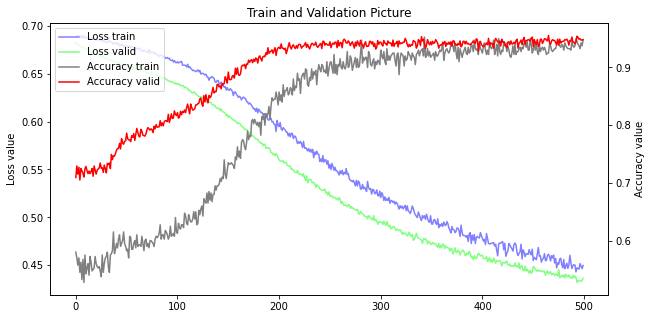

In [25]:
fig = plt.gcf()
fig.set_size_inches(10, 5)
ax1 = fig.add_subplot(111)
ax1.set_title('Train and Validation Picture')
ax1.set_ylabel('Loss value')
line1, = ax1.plot(train_loss_list, color=(0.5, 0.5, 1.0), label='Loss train')
line2, = ax1.plot(test_loss_list, color=(0.5, 1.0, 0.5), label='Loss valid')
ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy value')
line3, = ax2.plot(train_acc_list, color=(0.5, 0.5, 0.5), label='Accuracy train')
line4, = ax2.plot(test_acc_list, color=(1, 0, 0), label='Accuracy valid')
plt.legend(handles=(line1, line2, line3, line4), loc='best')
plt.show()